# Brain Tumor MRI Classification

#  Xception without Transfer Learning
### Author: Ethan Gilles

---

## Importing libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

## Setup cuda drivers

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cuda')

## Data loading

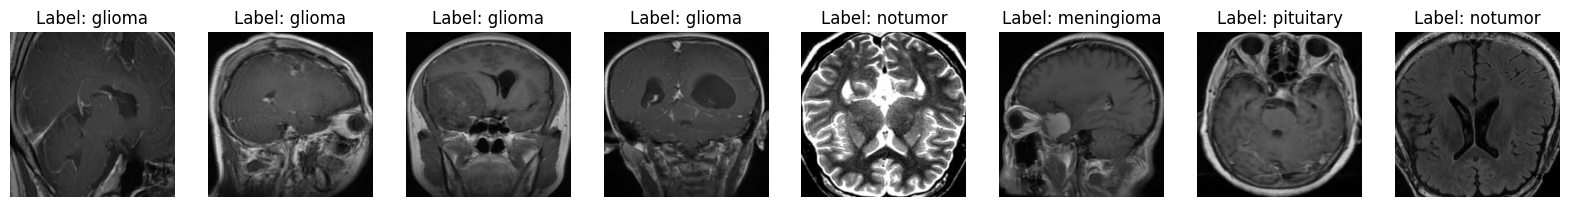

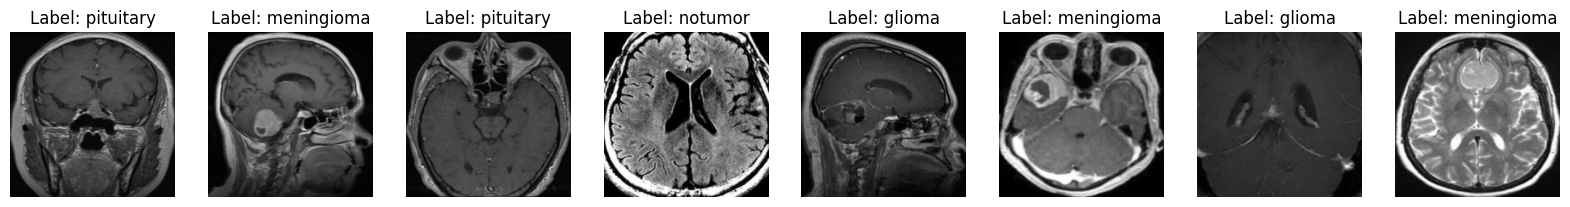

In [6]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

train_dataset = datasets.ImageFolder(root='data/training', transform=transform)
test_dataset = datasets.ImageFolder(root='data/testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(20, 3))

    random_indices = random.sample(range(len(dataset)), num_images)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Get the image and label
        image = image.numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
        image = (image * 0.5) + 0.5  # Undo normalization for visualization

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f'Label: {dataset.classes[label]}')
        plt.axis('off')

    plt.show()


visualize_images(train_dataset, num_images=8)
visualize_images(test_dataset, num_images=8)

## Create Xception Model

In [8]:
def create_model():
    base_model = timm.create_model('xception', pretrained=True, num_classes=0)  # No final layer
    model = nn.Sequential(
        base_model,
        nn.Flatten(),
        nn.Dropout(0.3),
        nn.Linear(base_model.num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 4),
        nn.Softmax(dim=1)
    )
    return model.to(device)
    
# Create model and define loss and optimizer
model = create_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/home/exan/anaconda3/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


## Training the Model

In [10]:
def train(model, train_loader, epochs=5):
    history = {"train_loss": [], "train_acc": []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    
    return history

history = train(model, train_loader, epochs=5)

Epoch 1/5, Loss: 0.9355, Accuracy: 84.98%
Epoch 2/5, Loss: 0.7769, Accuracy: 96.97%
Epoch 3/5, Loss: 0.7661, Accuracy: 97.85%
Epoch 4/5, Loss: 0.7607, Accuracy: 98.41%
Epoch 5/5, Loss: 0.7530, Accuracy: 99.16%


## Training Metrics

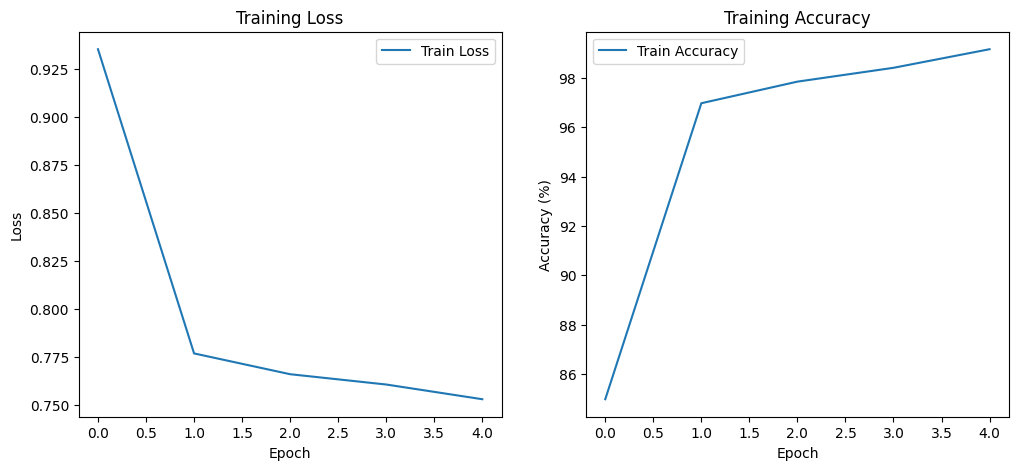

In [12]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label='Train Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.legend()
    
    plt.show()

plot_training_history(history)

## Testing phase

Test Accuracy: 97.49%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.98      0.98       303
  meningioma       0.99      0.92      0.96       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.95      1.00      0.97       300

    accuracy                           0.97      1314
   macro avg       0.97      0.97      0.97      1314
weighted avg       0.98      0.97      0.97      1314



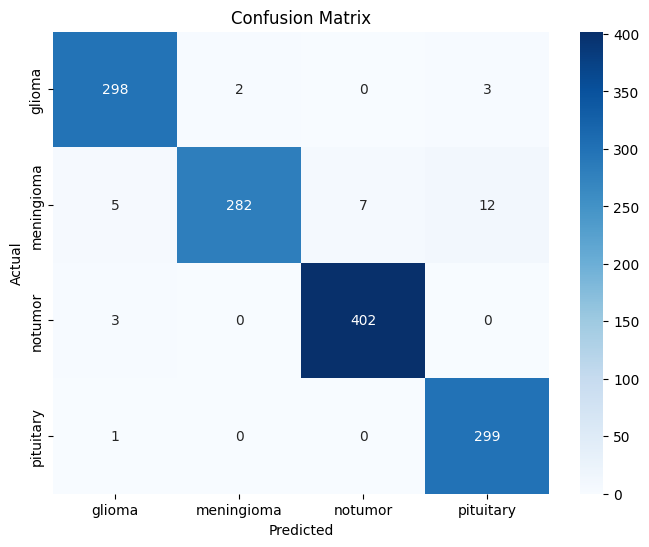

In [14]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


evaluate(model, test_loader)

## Save Weights

In [40]:
# Save the model weights
torch.save(model.state_dict(), 'xception_model_weights.pth')